# IT Operations: Root Cause Analysis

> A data center team wants to build a model to predict causes of issues reported by customers

## Problem Statement

> Using data about CPU load, memory load, networks delays, and other metrics, the team wants to predict the root cause 
> of issues reported by customers. The team has a dataset with 10,000 samples, each with 50 features. 
> The dataset has 10 classes, each representing a root cause of an issue. 
> The team wants to build a model that can predict the root cause of an issue with high accuracy.

> Feature variables: 
> - CPU load
> - Memory load
> - Network delays
> - Error 1000
> - Error 1001
> - Error 1002
> - Error 1003

> Target class:
> - Root cause of the issue

In [56]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import models as k_models
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

In [57]:
# Load the dataset
#Load the data file into a Pandas Dataframe
symptom_data = pd.read_csv("files/root_cause_analysis.csv")

#Explore the data loaded
print(symptom_data.dtypes)
symptom_data.head()

ID                   int64
CPU_LOAD             int64
MEMORY_LEAK_LOAD     int64
DELAY                int64
ERROR_1000           int64
ERROR_1001           int64
ERROR_1002           int64
ERROR_1003           int64
ROOT_CAUSE          object
dtype: object


,ID,CPU_LOAD,MEMORY_LEAK_LOAD,DELAY,ERROR_1000,ERROR_1001,ERROR_1002,ERROR_1003,ROOT_CAUSE
0,1,0,0,0,0,1,0,1,MEMORY_LEAK
1,2,0,0,0,0,0,0,1,MEMORY_LEAK
2,3,0,1,1,0,0,1,1,MEMORY_LEAK
3,4,0,1,0,1,1,0,1,MEMORY_LEAK
4,5,1,1,0,1,0,1,0,NETWORK_DELAY


In [58]:
# Feature engineering

label_encoder = LabelEncoder()
symptom_data['ROOT_CAUSE'] = label_encoder.fit_transform(
                                symptom_data['ROOT_CAUSE'])

#Convert Pandas DataFrame to a numpy vector
np_symptom = symptom_data.to_numpy().astype(float)

#Extract the feature variables (X)
X_data = np_symptom[:,1:8]

#Extract the target variable (Y), conver to one-hot-encodign
Y_data = np_symptom[:,8]
Y_data = utils.to_categorical(Y_data,3)

In [59]:

# Split data
X_train,X_test,Y_train,Y_test = train_test_split( X_data, Y_data, test_size=0.10)

print("Shape of feature variables :", X_train.shape)
print("Shape of target variable :",Y_train.shape)

Shape of feature variables : (900, 7)
Shape of target variable : (900, 3)



Evaluation against Test Dataset :
------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8739 - loss: 0.3495 

Model Accuracy :  0.8799999952316284

Model Loss :  0.33696651458740234
Best epoch :  0


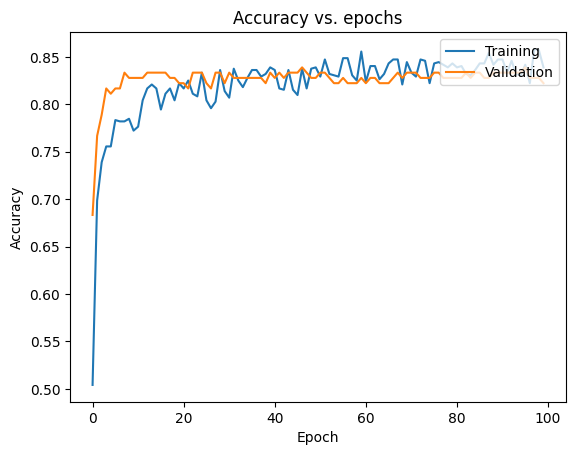

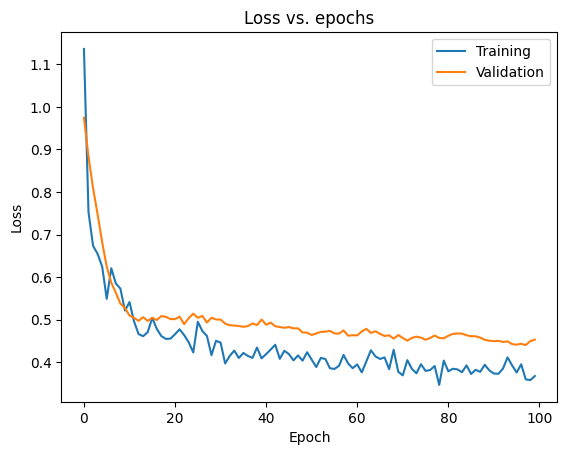

In [63]:
# Build a neural network model

#Setup Training Parameters
EPOCHS = 100
BATCH_SIZE = 32
VERBOSE = 0
OUTPUT_CLASSES = len(label_encoder.classes_)
N_HIDDEN = 64
VALIDATION_SPLIT = 0.2

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimum amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True, # keep the best model
)

#Create a Keras sequential model
model = k_models.Sequential([
    Input(shape=(7,)),
    BatchNormalization(),
    Dense(N_HIDDEN,  name='Dense-Layer-1', activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(N_HIDDEN, name='Dense-Layer-2', activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(OUTPUT_CLASSES, name='Output-Layer', activation='softmax')
])

#Compile the model
model.compile(
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# model.summary()

#Build the model
history = model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT,
          callbacks=[early_stopping]
                    )


#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
loss, accuracy = model.evaluate(X_test,Y_test)


# Show accuracy of the model
print("\nModel Accuracy : ", accuracy) # 0.87% accuracy
print("\nModel Loss : ", loss) # 0.87% accuracy

# best params
print("Best epoch : ", early_stopping.stopped_epoch)

# plot accuracy by epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Let's plot the loss over time.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [64]:
## Model Evaluation ( predict root cause )

CPU_LOAD=1
MEMORY_LOAD=0
DELAY=0
ERROR_1000=0
ERROR_1001=1
ERROR_1002=1
ERROR_1003=0

single_batch = np.array([[CPU_LOAD,MEMORY_LOAD,DELAY, ERROR_1000,ERROR_1001,ERROR_1002,ERROR_1003]])

multi_batch = np.array([
    [1,0,0,0,1,1,0],
    [0,1,1,1,0,0,0],
    [1,1,0,1,1,0,1],
    [0,0,0,0,0,1,0],
    [1,0,1,0,1,1,1]
])

print('Predicting a single sample :')

prediction = np.argmax(model.predict(single_batch), axis=1)
inv_prediction = label_encoder.inverse_transform(prediction)

print('Predicted Root Cause :',inv_prediction[0])

#Predicting as a Batch
print('\nPredicting a batch of samples :')
batch_predictions = np.argmax(model.predict(multi_batch), axis=1)
# Use label_encoder.inverse_transform on the batch predictions
inv_batch_predictions = label_encoder.inverse_transform(batch_predictions)

# Print the predicted root causes
print('Predicted Root Causes:', inv_batch_predictions)

Predicting a single sample :
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Root Cause : DATABASE_ISSUE

Predicting a batch of samples :
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted Root Causes: ['DATABASE_ISSUE' 'NETWORK_DELAY' 'MEMORY_LEAK' 'DATABASE_ISSUE'
 'DATABASE_ISSUE']


## Conclusion
> The model can predict the root cause of an issue with high accuracy. 
> The team can use this model to predict the root cause of issues reported by customers.
> The team can also use this model to predict the root cause of issues in real-time by integrating it with the monitoring system.
> The team can further improve the model by adding more features and tuning the hyperparameters.
